In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghost5612","key":"dff609f69209249df7df094cbb770ca9"}'}

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:23<00:00, 42.8MB/s]
100% 2.29G/2.29G [00:23<00:00, 106MB/s] 


In [5]:
!unzip -q chest-xray-pneumonia.zip -d chest-xray-pneumonia-data

In [6]:
import os

# Show first 10 files in the dataset
for root, dirs, files in os.walk("chest-xray-pneumonia-data"):
    for name in files[:10]:
        print(os.path.join(root, name))

chest-xray-pneumonia-data/chest_xray/test/NORMAL/IM-0093-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/IM-0067-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/NORMAL2-IM-0301-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/NORMAL2-IM-0141-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/IM-0019-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/NORMAL2-IM-0105-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/NORMAL2-IM-0305-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/IM-0085-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/NORMAL/NORMAL2-IM-0341-0001.jpeg
chest-xray-pneumonia-data/chest_xray/test/PNEUMONIA/person134_bacteria_642.jpeg
chest-xray-pneumonia-data/chest_xray/test/PNEUMONIA/person78_bacteria_384.jpeg
chest-xray-pneumonia-data/chest_xray/test/PNEUMONIA/person23_virus_56.jpeg
chest-xray-pneumonia-data/chest_xray/test/PNEUMO

In [7]:
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
import os
import shutil

root_dir = "chest-xray-pneumonia-data/chest_xray"
for subdir, dirs, files in os.walk(root_dir):
    for f in files:
        if f == ".DS_Store" or f.startswith("._"):
            os.remove(os.path.join(subdir, f))
nested_dir = os.path.join(root_dir, "chest_xray")
if os.path.exists(nested_dir):
    for sub in ["train", "test", "val"]:
        src = os.path.join(nested_dir, sub)
        dst = os.path.join(root_dir, sub)
        if os.path.exists(src) and not os.path.exists(dst):
            shutil.move(src, dst)
    shutil.rmtree(nested_dir, ignore_errors=True)
print("Dataset cleaned successfully!")
print("Train:", len(os.listdir(os.path.join(root_dir, "train/NORMAL"))),
      "+", len(os.listdir(os.path.join(root_dir, "train/PNEUMONIA"))))
print("Test:", len(os.listdir(os.path.join(root_dir, "test/NORMAL"))),
      "+", len(os.listdir(os.path.join(root_dir, "test/PNEUMONIA"))))
print("Val:", len(os.listdir(os.path.join(root_dir, "val/NORMAL"))),
      "+", len(os.listdir(os.path.join(root_dir, "val/PNEUMONIA"))))

Dataset cleaned successfully!
Train: 1341 + 3875
Test: 234 + 390
Val: 8 + 8


In [11]:
import os
import pandas as pd

def create_dataframe(root_dir):
    data = []
    classes = ["NORMAL", "PNEUMONIA"]
    for label, cls in enumerate(classes):
        class_dir = os.path.join(root_dir, cls)
        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            data.append({"image_path": img_path, "label": label})
    return pd.DataFrame(data)
base_dir = "chest-xray-pneumonia-data/chest_xray"
train_df = create_dataframe(os.path.join(base_dir, "train"))
val_df   = create_dataframe(os.path.join(base_dir, "val"))
test_df  = create_dataframe(os.path.join(base_dir, "test"))

In [9]:
class LungXDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
IMG_SIZE = 224 # Input size for EfficientNetV2-S
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
train_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [12]:
BATCH_SIZE = 32

train_dataset = LungXDataset(train_df, transform=train_transform)
val_dataset = LungXDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train_loader
val_loader

In [13]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels: {labels[:10]}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1])


In [15]:
idx_to_class = {0: "NORMAL", 1: "PNEUMONIA"}
print(idx_to_class)


{0: 'NORMAL', 1: 'PNEUMONIA'}


In [24]:
import torch.nn as nn
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNetV2-S
model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
# Number of classes (NORMAL, PNEUMONIA)
num_classes = 2
# Replace classifier head
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

In [25]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [40]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    # Lists to store metrics for plotting
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0.0
    patience_counter = 0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        # Training
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
        train_acc = 100 * train_correct / len(train_loader.dataset)
        val_acc = 100 * val_correct / len(val_loader.dataset)
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        # Save history for plotting
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        # Logging
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        # Check for best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Optional: stop immediately if 100% validation accuracy
        if val_acc == 100.0:
            print(f"Validation accuracy reached 100% at epoch {epoch+1}, stopping training.")
            break
        scheduler.step()
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [41]:
model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5
)



Epoch 1/25
------------------------------
Train Loss: 0.0620, Accuracy: 98.04%
Val Loss: 0.1348, Accuracy: 93.75%
Best model saved!

Epoch 2/25
------------------------------
Train Loss: 0.0623, Accuracy: 97.76%
Val Loss: 0.1677, Accuracy: 87.50%

Epoch 3/25
------------------------------
Train Loss: 0.0596, Accuracy: 98.04%
Val Loss: 0.1294, Accuracy: 93.75%

Epoch 4/25
------------------------------
Train Loss: 0.0627, Accuracy: 97.68%
Val Loss: 0.1554, Accuracy: 87.50%

Epoch 5/25
------------------------------
Train Loss: 0.0594, Accuracy: 98.14%
Val Loss: 0.1051, Accuracy: 100.00%
Best model saved!
Validation accuracy reached 100% at epoch 5, stopping training.


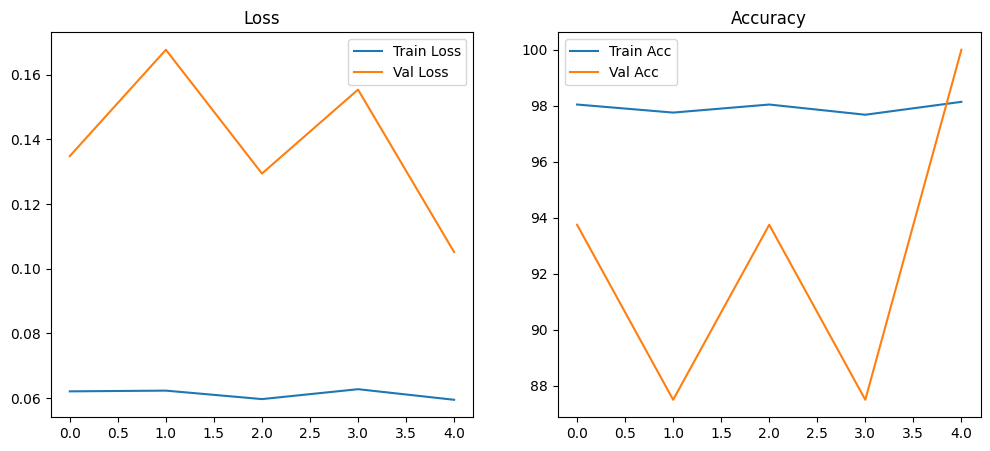

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()


In [43]:
import matplotlib.pyplot as plt

predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict_image(model, image_path, idx_to_class):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = predict_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0][pred_class].item()

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {idx_to_class[pred_class]} ({confidence:.2f})")
    plt.show()

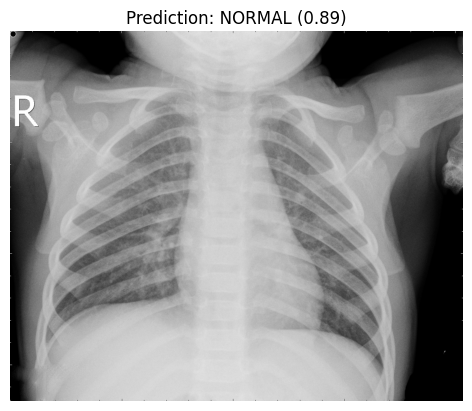

In [44]:
predict_image(model, val_df.iloc[2]['image_path'], idx_to_class)

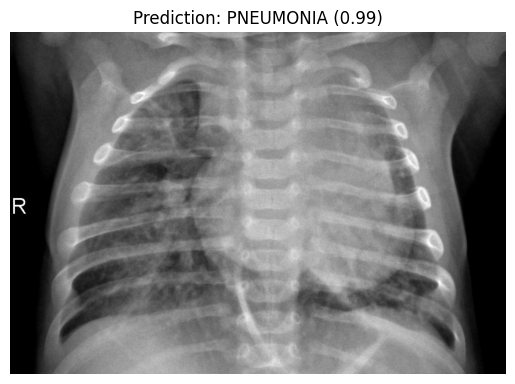

In [49]:
import torch
from torchvision import models
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_v2_s(pretrained=False)
num_classes = 2
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model.load_state_dict(torch.load("/content/ChestXRay(Pneumonia-Detection)Model.pth", map_location=device))
model = model.to(device)

idx_to_class = {0: "NORMAL", 1: "PNEUMONIA"}

predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict_image(model, image_path, idx_to_class):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = predict_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0][pred_class].item()

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {idx_to_class[pred_class]} ({confidence:.2f})")
    plt.show()

# Call the function with your test image
test_image_path = "/content/chest-xray-pneumonia-data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
predict_image(model, test_image_path, idx_to_class)


In [50]:
torch.save(model.state_dict(), "/content/ChestXRay(Pneumonia-Detection)Model_State_Dict.pth")

In [51]:
torch.save(model, "/content/ChestXRay(Pneumonia-Detection)EntireModel.pth")